In [ ]:
!pip install scikit-optimize

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC

In [18]:
class StackingTransformer(BaseEstimator, TransformerMixin):
    """A transformer that wraps a RegressorMixin `est` predict function.
    
    It overloads `fit_transform` to do a stacked transform to avoid leakage.
    """
    def __init__(self, est):
        self.est = est
        
    def fit(self, X, y=None):
        if y is None:
            raise ValueError('{}.fit requires y to be not None'.format(self))
        self.est.fit(X, y)
        return self
    
    def transform(self, X):
        return self.est.predict(X)[:, np.newaxis]
    
    def fit_transform(self, X, y=None):
        if y is None:
            raise ValueError('{}.fit requires y to be not None'.format(self))
        self.models_ = []
        out = np.empty_like(y)[:, np.newaxis]
        for train, test in KFold(5, shuffle=True, random_state=0).split(X):
            self.models_.append(clone(self.est).fit(X[train], y[train]))
            out[test, 0] = self.models_[-1].predict(X[test])
        self.est = self.models_[0]
        return out

In [19]:
# 1. Reads provided data.
url = 'https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Fire_Ins_Loss_only.csv'
df = pd.read_csv(url)
df.head()

,loss,Exposure,Rating_Class,Sub_Rating_Class,Renewal_class,Sub_Renewal_Class,Property_size,Residents,Commercial,Norm_fire_risk,...,crime_arson,crime_burglary,crime_neighbour_watch,crime_community,crime_risk,Geographical_risk,Weather_risk,ISO,ISO_cat,ISO_desc
0,0.07,3.0,H1,NaN,NaN,NaN,3.0,4.0,NaN,4.314082,...,0.939346,1.708534,0.808015,1.040819,1.171366,0.284447,0.313157,5,ISO 5 - Modified or Semi Fire Resistive (MFR o...,which and floors. greater roof _—– modified an...
1,0.13,NaN,M1,NaN,NaN,NaN,6.0,1.0,NaN,4.171214,...,NaN,NaN,NaN,NaN,NaN,0.006305,0.889677,6,ISO 6 - Fire Resistive (FR),bearing are walls deck/cover precast and/or co...
2,0.02,NaN,M1,NaN,NaN,NaN,4.0,1.0,NaN,4.171214,...,NaN,NaN,NaN,NaN,NaN,0.019372,0.276507,1,ISO 1 Frame (combustible walls or roof),*BUR 1B and covers the *Single-ply wood/hardip...
3,0.13,NaN,M1,NaN,NaN,NaN,2.0,1.0,NaN,4.171214,...,1.632539,1.205554,1.999838,1.665336,1.779279,0.085413,0.124679,1,ISO 1 Frame (combustible walls or roof),"frame anchorage are wood. *Less Habitational, ..."
4,0.04,3.0,H1,NaN,NaN,NaN,4.0,3.0,NaN,4.314082,...,0.638615,0.567431,0.751454,0.585363,0.729587,5.570830,0.703054,6,ISO 6 - Fire Resistive (FR),is roof deck structural on roof - poured occup...


In [20]:
# 2. Does exploratory data analysis.
types_dict = {
  "object": "Categorical",
  "float64": "Numeric",
  "int64": "Numeric",
  "datetime64[ns]": "DateTime"
}
dict_types = {}
def get_categories(data_frame):
    for col in data_frame.columns:
        if(str(df[col].dtype)=='object' and df[col].nunique() > df[col].count()*0.6 ):
            print(f"{col} - Text")
            dict_types[str(col)]="Text"
        else:
            print(f"{col} - {types_dict[str(df[col].dtype)]}")  
            dict_types[str(col)]=str(types_dict[str(df[col].dtype)])
            


In [21]:
get_categories(df)
print(dict_types)

loss - Numeric
Exposure - Numeric
Rating_Class - Categorical
Sub_Rating_Class - Categorical
Renewal_class - Categorical
Sub_Renewal_Class - Categorical
Property_size - Numeric
Residents - Numeric
Commercial - Categorical
Norm_fire_risk - Numeric
Norm_monthly_rent - Numeric
Loan_mortgage - Numeric
No_claim_Years - Numeric
Previous_claims - Numeric
Norm_area_m - Numeric
Premium_remain - Numeric
Premium_renew - Numeric
Renewal_Type - Categorical
crime_property_type - Numeric
crime_residents - Numeric
crime_area - Numeric
crime_arson - Numeric
crime_burglary - Numeric
crime_neighbour_watch - Numeric
crime_community - Numeric
crime_risk - Numeric
Geographical_risk - Numeric
Weather_risk - Numeric
ISO - Numeric
ISO_cat - Categorical
ISO_desc - Text
{'loss': 'Numeric', 'Exposure': 'Numeric', 'Rating_Class': 'Categorical', 'Sub_Rating_Class': 'Categorical', 'Renewal_class': 'Categorical', 'Sub_Renewal_Class': 'Categorical', 'Property_size': 'Numeric', 'Residents': 'Numeric', 'Commercial': 'Cat

In [22]:
target_feature  = 'loss'
categorical_features = ['Rating_Class', 'Sub_Rating_Class', 'Renewal_class', 'Sub_Renewal_Class', 'Commercial', 'Renewal_Type', 'ISO_cat']
numeric_features = ['Exposure', 'Property_size', 'Residents', 'Norm_fire_risk', 'Norm_monthly_rent', 'Loan_mortgage', 'No_claim_Years', 'Previous_claims', 'Norm_area_m', 
                    'Premium_remain', 'Premium_renew', 'crime_property_type', 'crime_residents', 'crime_area', 'crime_arson', 'crime_burglary', 'crime_neighbour_watch',
                    'crime_community', 'crime_risk', 'Geographical_risk', 'Weather_risk', 'ISO']
text_features = ['ISO_desc']

In [23]:
y = df.pop(target_feature)
X = df

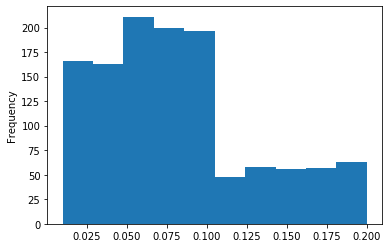

In [24]:
y.plot.hist(50)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

# y should be an ndarray
y_train = y_train.values
y_test = y_test.values

In [26]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-99999)),
    ])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('fx_selection', SelectFromModel(ElasticNet(alpha=0.1), max_features=50, threshold=None))
])

text_pipeline = Pipeline(steps=[
    ('bow', CountVectorizer()),
    ('bow_reg', StackingTransformer(ElasticNet(alpha=0.1)))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('text', text_pipeline, text_features[0])
    ])

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
opt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', LinearRegression())])
opt.fit(X_train, y_train)
print("model score: %.3f" % mean_absolute_error(y_test, est.predict(X_test)))

model score: 0.035


In [27]:
param_grid = {'rf__n_estimators': Integer( 100, 1000, prior='uniform'),
              'rf__max_depth': Integer(1, 25, prior='uniform'),
              'rf__max_features': Integer(2, 10, prior='uniform')}
opt = BayesSearchCV( 
    est,
    param_grid,
    optimizer_kwargs={'base_estimator': 'RF'},
    n_iter=40,
    cv=4,
    random_state=0)
opt.fit(X_train, y_train)

BayesSearchCV(cv=4, error_score='raise',
              estimator=Pipeline(memory=None,
                                 steps=[('preprocessor',
                                         ColumnTransformer(n_jobs=None,
                                                           remainder='drop',
                                                           sparse_threshold=0.3,
                                                           transformer_weights=None,
                                                           transformers=[('num',
                                                                          Pipeline(memory=None,
                                                                                   steps=[('imputer',
                                                                                           SimpleImputer(add_indicator=False,
                                                                                                         copy=True,
                    

In [35]:
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.2113540423170325
test score: 0.2526586691619216
